In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import warnings
import traceback
from astropy.constants import G
import astropy.units as u
import symlib
import colossus.cosmology as cosmology

sim_colors = {
    'SymphonyLMC': sns.color_palette("colorblind")[4],
    'SymphonyMilkyWay': sns.color_palette("colorblind")[0],
    'SymphonyGroup': sns.color_palette("colorblind")[2],
    'SymphonyLCluster': sns.color_palette("colorblind")[1],
    'SymphonyCluster': sns.color_palette("colorblind")[3]
}

In [ ]:
def plot_combined_ppsd_and_slopes(base_dir, suite_names):
    from matplotlib import gridspec

    fig_ppsd = plt.figure(figsize=(14, 12), dpi=500)
    gs_ppsd = gridspec.GridSpec(3, 2, height_ratios=[3, 3, 1])
    ax_ppsd = [fig_ppsd.add_subplot(gs_ppsd[0, 0]),
               fig_ppsd.add_subplot(gs_ppsd[0, 1]),
               fig_ppsd.add_subplot(gs_ppsd[1, 0]),
               fig_ppsd.add_subplot(gs_ppsd[1, 1])]
    ax_resid = [fig_ppsd.add_subplot(gs_ppsd[2, 0]),
                fig_ppsd.add_subplot(gs_ppsd[2, 1])]

    fig_slope, axes_slope = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    ax_slope = axes_slope.flatten()

    interp_m = np.logspace(-4, 0, 200)

    def load_ppsd_profiles(suite):
        dir_path = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        files = sorted([f for f in os.listdir(dir_path) if f.endswith(".csv")])
        r_list, m_list, Qr_list, Qtot_list = [], [], [], []
        for f in files:
            df = pd.read_csv(os.path.join(dir_path, f))
            r_list.append(df["r_scaled"].values)
            m_list.append(df["m_scaled"].values)
            Qr_list.append(df["Q_r"].values)
            Qtot_list.append(df["Q_tot"].values)
        return r_list, m_list, Qr_list, Qtot_list

    def load_slope_profiles(suite):
        dir_r = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        dir_m = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_m")
        files_r = sorted([f for f in os.listdir(dir_r) if f.endswith(".csv")])
        files_m = sorted([f for f in os.listdir(dir_m) if f.endswith(".csv")])
        r_list, m_list, slope_r_Qr, slope_r_Qtot, slope_m_Qr, slope_m_Qtot = [], [], [], [], [], []
        for fr, fm in zip(files_r, files_m):
            dfr = pd.read_csv(os.path.join(dir_r, fr))
            dfm = pd.read_csv(os.path.join(dir_m, fm))
            r_list.append(dfr["r_scaled"].values)
            m_list.append(dfm["m_scaled"].values)
            slope_r_Qr.append(dfr["slope_Q_r"].values)
            slope_r_Qtot.append(dfr["slope_Q_tot"].values)
            slope_m_Qr.append(dfm["slope_Q_r"].values)
            slope_m_Qtot.append(dfm["slope_Q_tot"].values)
        return r_list, m_list, slope_r_Qr, slope_r_Qtot, slope_m_Qr, slope_m_Qtot

    def interpolate_curves(x_target, x_list, y_list):
        return np.array([
            np.interp(x_target, x, y, left=np.nan, right=np.nan)
            for x, y in zip(x_list, y_list)
            if np.all(np.isfinite(x)) and np.all(np.isfinite(y))
        ])

    Qr_all_r, Qtot_all_r, r_all = [], [], []

    for suite in suite_names:
        color = sim_colors.get(suite, "gray")
        r_list, m_list, Qr_list, Qtot_list = load_ppsd_profiles(suite)

        # Use radius directly without interpolation
        Qr_all_r.extend(Qr_list)
        Qtot_all_r.extend(Qtot_list)
        r_all = r_list[0]  # Assuming aligned

        Qr_arr = np.array(Qr_list)
        Qtot_arr = np.array(Qtot_list)

        for ax, data in zip(ax_ppsd[:2], [Qr_arr, Qtot_arr]):
            mean = np.nanmean(data, axis=0)
            std = np.nanstd(data, axis=0)
            ax.plot(r_list[0], mean, color=color, label=suite)
            ax.fill_between(r_list[0], mean - std, mean + std, color=color, alpha=0.3)

        Qr_interp_m = interpolate_curves(interp_m, m_list, Qr_list)
        Qtot_interp_m = interpolate_curves(interp_m, m_list, Qtot_list)

        for ax, data in zip(ax_ppsd[2:], [Qr_interp_m, Qtot_interp_m]):
            mean = np.nanmean(data, axis=0)
            std = np.nanstd(data, axis=0)
            ax.plot(interp_m, mean, color=color, label=suite)
            ax.fill_between(interp_m, mean - std, mean + std, color=color, alpha=0.3)

        r_slope, m_slope, sr_Qr, sr_Qtot, sm_Qr, sm_Qtot = load_slope_profiles(suite)

        slope_interp_m_Qr = interpolate_curves(interp_m, m_slope, sm_Qr)
        slope_interp_m_Qtot = interpolate_curves(interp_m, m_slope, sm_Qtot)

        for i, (interp, x_vals) in enumerate(zip(
            [sr_Qr, sr_Qtot, slope_interp_m_Qr, slope_interp_m_Qtot],
            [r_list[0], r_list[0], interp_m, interp_m])):
            data = np.array(interp)
            mean = np.nanmean(data, axis=0)
            std = np.nanstd(data, axis=0)
            ax_slope[i].plot(x_vals, mean, color=color, label=suite)
            ax_slope[i].fill_between(x_vals, mean - std, mean + std, color=color, alpha=0.3)

        mean_Qr = np.nanmean(Qr_arr, axis=0)
        mean_Qtot = np.nanmean(Qtot_arr, axis=0)
        A_r = np.exp(np.nanmean(np.log(mean_Qr) + 1.875 * np.log(r_list[0])))
        A_tot = np.exp(np.nanmean(np.log(mean_Qtot) + 1.875 * np.log(r_list[0])))
        ref_Qr = A_r * r_list[0]**(-1.875)
        ref_Qtot = A_tot * r_list[0]**(-1.875)

        resid_Qr = np.log10(Qr_arr / ref_Qr)
        resid_Qtot = np.log10(Qtot_arr / ref_Qtot)

        ax_resid[0].plot(r_list[0], np.nanmean(resid_Qr, axis=0), color=color, label=suite)
        ax_resid[1].plot(r_list[0], np.nanmean(resid_Qtot, axis=0), color=color, label=suite)
        
    labels = ["$Q_r$ vs $r$", "$Q_{tot}$ vs $r$", "$Q_r$ vs $M$", "$Q_{tot}$ vs $M$"]
    for i, ax in enumerate(ax_ppsd):
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("r / $R_{vir}$" if i < 2 else "M(<r) / $M_{vir}$")
        ax.set_ylabel("Q")
        ax.set_title(labels[i])
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    for ax in ax_resid:
        ax.set_xscale("log")
        ax.set_xlabel("r / $R_{vir}$")
        ax.set_ylabel("log$_{10}$(residual)")
        ax.grid(True, which="both", linestyle=":")


    for i, ax in enumerate(ax_slope):
        ax.set_xscale("log")
        ax.set_xlabel("r / $R_{vir}$" if i < 2 else "M(<r) / $M_{vir}$")
        ax.set_ylabel("Slope")
        ax.set_title(labels[i])
        ax.grid(True, which="both", linestyle=":")
        ax.axhline(-1.875, color="black", lw=0.9, ls="--")
        ax.legend()

    fig_ppsd.suptitle("PPSD Profiles with Residuals: Mean ± 1σ across Suites", fontsize=16)
    fig_slope.suptitle("PPSD Slope Profiles: Mean ± 1σ across Suites", fontsize=16)

    out_dir = os.path.join(base_dir, "output", "Combined")
    os.makedirs(out_dir, exist_ok=True)
    fig_ppsd.tight_layout(rect=[0, 0, 1, 0.96])
    fig_slope.tight_layout(rect=[0, 0, 1, 0.96])
    fig_ppsd.savefig(os.path.join(out_dir, "ppsd_profiles_comparison_with_residuals.png"))
    fig_slope.savefig(os.path.join(out_dir, "ppsd_slope_profiles_comparison.png"))
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster"
]

plot_combined_ppsd_and_slopes(base_dir, suite_names)

In [ ]:
def plot_ppsd_split_by_concentration_and_accretion(base_dir, suite_names):
    def mean_std_plot(ax, x_list, y_list, mean_param, label_prefix, color, sci=False):
        if len(x_list) == 0 or len(y_list) == 0:
            return
        x_ref = x_list[0]
        y_stack = np.stack(y_list)
        y_mean = np.nanmean(y_stack, axis=0)
        y_std = np.nanstd(y_stack, axis=0)
        param_fmt = f"{mean_param:.2e}" if sci else f"{mean_param:.2f}"
        label = f"{label_prefix} (⟨⟩={param_fmt}, N={len(y_list)})"
        ax.plot(x_ref, y_mean, color=color, lw=0.9, label=label)
        ax.fill_between(x_ref, y_mean - y_std, y_mean + y_std, color=color, alpha=0.3)

    r_low, r_high, m_low, m_high = [], [], [], []
    Qr_low_c, Qr_high_c, Qtot_low_c, Qtot_high_c = [], [], [], []
    Qr_low_g, Qr_high_g, Qtot_low_g, Qtot_high_g = [], [], [], []
    cvir_low, cvir_high, gamma_low, gamma_high = [], [], [], []
    cvir_medians, gamma_medians = [], []

    for suite in suite_names:
        ppsd_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        files = sorted([f for f in os.listdir(ppsd_dir) if f.endswith(".csv")])

        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        acc_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        cvir_df = pd.read_csv(cvir_path)
        cvir_dict = dict(zip(cvir_df["halo_id"], cvir_df["cvir"]))
        df_gamma = pd.read_csv(acc_path)
        gamma_dict = dict(zip(df_gamma["halo_index"], df_gamma["gamma"]))

        cvir_list, gamma_list = [], []
        r_list, m_list, Qr_list, Qtot_list = [], [], [], []

        for i, f in enumerate(files):
            try:
                halo_id = int(f.split("_")[1])
                df = pd.read_csv(os.path.join(ppsd_dir, f))
                r = df["r_scaled"].values
                m = df["m_scaled"].values
                Qr = df["Q_r"].values
                Qtot = df["Q_tot"].values

                cvir = cvir_dict.get(halo_id, np.nan)
                gamma = gamma_dict.get(halo_id, np.nan)
            except:
                continue

            r_list.append(r)
            m_list.append(m)
            Qr_list.append(Qr)
            Qtot_list.append(Qtot)
            cvir_list.append(cvir)
            gamma_list.append(gamma)

        cvir_median = np.nanmedian(cvir_list)
        gamma_median = np.nanmedian(gamma_list)
        cvir_medians.append(cvir_median)
        gamma_medians.append(gamma_median)

        for r, m, Qr, Qtot, c, g in zip(r_list, m_list, Qr_list, Qtot_list, cvir_list, gamma_list):
            if not np.all(np.isfinite(Qr)) or not np.all(np.isfinite(Qtot)):
                continue
            if c <= cvir_median:
                r_low.append(r)
                m_low.append(m)
                Qr_low_c.append(Qr)
                Qtot_low_c.append(Qtot)
                cvir_low.append(c)
            else:
                r_high.append(r)
                m_high.append(m)
                Qr_high_c.append(Qr)
                Qtot_high_c.append(Qtot)
                cvir_high.append(c)

            if g <= gamma_median:
                Qr_low_g.append(Qr)
                Qtot_low_g.append(Qtot)
                gamma_low.append(g)
            else:
                Qr_high_g.append(Qr)
                Qtot_high_g.append(Qtot)
                gamma_high.append(g)

    def finalize(axs, r_Qr, r_Qtot, m_Qr, m_Qtot,
                 low_label, high_label, colors,
                 low_param, high_param, sci=False):
        mean_std_plot(axs[0], r_low, r_Qr[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[0], r_high, r_Qr[1], high_param, high_label, colors[1], sci)
        axs[0].set_title(r"$Q_r$ vs $r$")

        mean_std_plot(axs[1], r_low, r_Qtot[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[1], r_high, r_Qtot[1], high_param, high_label, colors[1], sci)
        axs[1].set_title(r"$Q_{\rm tot}$ vs $r$")

        mean_std_plot(axs[2], m_low, m_Qr[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[2], m_high, m_Qr[1], high_param, high_label, colors[1], sci)
        axs[2].set_title(r"$Q_r$ vs $M$")

        mean_std_plot(axs[3], m_low, m_Qtot[0], low_param, low_label, colors[0], sci)
        mean_std_plot(axs[3], m_high, m_Qtot[1], high_param, high_label, colors[1], sci)
        axs[3].set_title(r"$Q_{\rm tot}$ vs $M$")

        for ax in axs:
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlabel("r / Rvir" if "r" in ax.get_title() else "M / Mvir")
            ax.set_ylabel("PPSD")
            ax.grid(True, which="both", linestyle=":")
            ax.legend()

    os.makedirs(os.path.join(base_dir, "output", "combined", "figures"), exist_ok=True)

    fig_c, axes_c = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    finalize(axes_c.flatten(),
             [Qr_low_c, Qr_high_c], [Qtot_low_c, Qtot_high_c],
             [Qr_low_c, Qr_high_c], [Qtot_low_c, Qtot_high_c],
             "Low c", "High c", ["steelblue", "firebrick"],
             np.mean(cvir_low), np.mean(cvir_high), sci=False)
    fig_c.suptitle("PPSD by Concentration (Per-suite split)", fontsize=16)
    fig_c.tight_layout(rect=[0, 0, 1, 0.96])
    fig_c.savefig(os.path.join(base_dir, "output", "combined", "ppsd_profiles_by_concentration.png"))

    fig_a, axes_a = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    finalize(axes_a.flatten(),
             [Qr_low_g, Qr_high_g], [Qtot_low_g, Qtot_high_g],
             [Qr_low_g, Qr_high_g], [Qtot_low_g, Qtot_high_g],
             "Low Accretion", "High Accretion", ["seagreen", "orange"],
             np.mean(gamma_low), np.mean(gamma_high), sci=True)
    fig_a.suptitle("PPSD by Accretion Rate (Per-suite split)", fontsize=16)
    fig_a.tight_layout(rect=[0, 0, 1, 0.96])
    fig_a.savefig(os.path.join(base_dir, "output", "combined", "ppsd_profiles_by_accretion.png"))

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup"
]

plot_ppsd_split_by_concentration_and_accretion(base_dir, suite_names)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_ppsd_slope_vs_concentration_and_accretion(base_dir, suite_names):
    def load_slope_data(suite):
        slope_r_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        slope_m_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_m")
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")

        cvir_df = pd.read_csv(cvir_path)
        gamma_df = pd.read_csv(gamma_path)
        cvir_dict = dict(zip(cvir_df["halo_id"], cvir_df["cvir"]))
        gamma_dict = dict(zip(gamma_df["halo_index"], gamma_df["gamma"]))

        files = sorted([f for f in os.listdir(slope_r_dir) if f.startswith("halo_") and f.endswith(".csv")])
        data = []

        for f in files:
            try:
                halo_id = int(f.split("_")[1])
                dfr = pd.read_csv(os.path.join(slope_r_dir, f))
                dfm = pd.read_csv(os.path.join(slope_m_dir, f))

                r = dfr["r_scaled"].values
                m = dfm["m_scaled"].values
                sr_Qtot = dfr["slope_Q_tot"].values
                sr_Qr = dfr["slope_Q_r"].values
                sm_Qtot = dfm["slope_Q_tot"].values
                sm_Qr = dfm["slope_Q_r"].values

                cvir = cvir_dict.get(halo_id, np.nan)
                gamma = gamma_dict.get(halo_id, np.nan)

                data.append({
                    "halo_id": halo_id,
                    "r": r,
                    "m": m,
                    "sr_Qtot": sr_Qtot,
                    "sr_Qr": sr_Qr,
                    "sm_Qtot": sm_Qtot,
                    "sm_Qr": sm_Qr,
                    "cvir": cvir,
                    "gamma": gamma
                })
            except Exception as e:
                print(f"[Warning] Failed to process {f} in {suite}: {e}")
                continue
        return data

    def group_by_quartiles(data, key):
        values = np.array([d[key] for d in data])
        q25, q50, q75 = np.nanpercentile(values, [25, 50, 75])
        q1 = [d for d in data if d[key] <= q25]
        q2 = [d for d in data if q25 < d[key] <= q50]
        q3 = [d for d in data if q50 < d[key] <= q75]
        q4 = [d for d in data if d[key] > q75]
        return q1, q2, q3, q4

    def interpolate_group(group, key_x, key_y, x_common):
        y_interp = []
        for d in group:
            x, y = d[key_x], d[key_y]
            mask = np.isfinite(x) & np.isfinite(y)
            if np.sum(mask) < 2:
                continue
            try:
                f = interp1d(x[mask], y[mask], bounds_error=False, fill_value=np.nan)
                y_interp.append(f(x_common))
            except:
                continue
        return np.array(y_interp)

    def plot_slope_panels(axs, groups, x_key, y_keys, x_label, use_sci=False):
        x_common = np.logspace(-3, 0, 200) 
        titles = [r"$\mathrm{d}\log Q / \mathrm{d}\log x$", r"$\mathrm{d}\log Q_r / \mathrm{d}\log x$"]
        group_names = ["Q1 (0–25%)", "Q2 (25–50%)", "Q3 (50–75%)", "Q4 (75–100%)"]
        colors = ["#9ebcda", "#8c96c6", "#fb9a99", "#e31a1c"]

        for i, y_key in enumerate(y_keys):
            for group, name, color in zip(groups, group_names, colors):
                y_interp = interpolate_group(group, x_key, y_key, x_common)
                if len(y_interp) == 0:
                    continue
                y_mean = np.nanmean(y_interp, axis=0)
                y_std = np.nanstd(y_interp, axis=0)

                vals = [d["gamma" if use_sci else "cvir"] for d in group]
                val = np.nanmean(vals)
                fmt_val = f"{val:.1e}" if use_sci else f"{val:.2f}"
                label = f"{name} ({fmt_val}, N={len(group)})"

                axs[i].plot(x_common, y_mean, label=label, color=color, lw=1)
                #axs[i].fill_between(x_common, y_mean - y_std, y_mean + y_std, alpha=0.3, color=color)

            axs[i].set_xscale("log")
            axs[i].set_xlabel(x_label)
            axs[i].set_ylabel(titles[i].replace("x", "r" if x_key == "r" else "M"))
            axs[i].legend()
            axs[i].grid(True, which="both", linestyle=":")

            if x_key == "r":
                axs[i].axhline(-1.875, color="gray", linestyle="--", linewidth=1, label=r"$-1.875$")
                axs[i].set_ylim(-2.2, -1.5)
            else:
                axs[i].set_ylim(-1.5, -1)

    # Quartile group containers
    all_c_q1, all_c_q2, all_c_q3, all_c_q4 = [], [], [], []
    all_g_q1, all_g_q2, all_g_q3, all_g_q4 = [], [], [], []

    for suite in suite_names:
        suite_data = load_slope_data(suite)
        c_q1, c_q2, c_q3, c_q4 = group_by_quartiles(suite_data, "cvir")
        g_q1, g_q2, g_q3, g_q4 = group_by_quartiles(suite_data, "gamma")

        all_c_q1.extend(c_q1)
        all_c_q2.extend(c_q2)
        all_c_q3.extend(c_q3)
        all_c_q4.extend(c_q4)

        all_g_q1.extend(g_q1)
        all_g_q2.extend(g_q2)
        all_g_q3.extend(g_q3)
        all_g_q4.extend(g_q4)

    output_dir = os.path.join(base_dir, "output", "combined")
    os.makedirs(output_dir, exist_ok=True)

    # ---- Concentration Figure ----
    fig_c, axes_c = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    plot_slope_panels(axes_c[0], [all_c_q1, all_c_q2, all_c_q3, all_c_q4], "r", ["sr_Qtot", "sr_Qr"], r"$r / R_{\rm vir}$")
    plot_slope_panels(axes_c[1], [all_c_q1, all_c_q2, all_c_q3, all_c_q4], "m", ["sm_Qtot", "sm_Qr"], r"$M(<r) / M_{\rm vir}$")
    fig_c.suptitle("PPSD Slope vs Concentration Quartiles")
    fig_c.tight_layout()
    fig_c.savefig(os.path.join(output_dir, "ppsd_slope_vs_concentration_quartiles.png"))

    # ---- Accretion Rate Figure ----
    fig_g, axes_g = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    plot_slope_panels(axes_g[0], [all_g_q1, all_g_q2, all_g_q3, all_g_q4], "r", ["sr_Qtot", "sr_Qr"], r"$r / R_{\rm vir}$", use_sci=True)
    plot_slope_panels(axes_g[1], [all_g_q1, all_g_q2, all_g_q3, all_g_q4], "m", ["sm_Qtot", "sm_Qr"], r"$M(<r) / M_{\rm vir}$", use_sci=True)
    fig_g.suptitle("PPSD Slope vs Accretion Rate Quartiles")
    fig_g.tight_layout()
    fig_g.savefig(os.path.join(output_dir, "ppsd_slope_vs_accretion_quartiles.png"))

    plt.show()
    plt.close('all')
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup"
]

plot_ppsd_slope_vs_concentration_and_accretion(base_dir, suite_names)

In [ ]:
def save_mass(base_dir, suite_name, output):
    output_dir = os.path.join(output, "output", suite_name)
    os.makedirs(output_dir, exist_ok=True)

    n_halos = symlib.n_hosts(suite_name)
    halo_ids, mvir_list = [], []

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)
        try:
            r, _ = symlib.read_rockstar(sim_dir)
            mvir = r[0, -1]["m"] 
            halo_ids.append(f'{halo_idx:03d}')
            mvir_list.append(mvir)
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

    df = pd.DataFrame({"halo_id": halo_ids, "mvir": mvir_list})
    df.to_csv(os.path.join(output_dir, "halo_mass.csv"), index=False)
    print(f"[Saved] Mass CSV to {output_dir}/halo_mass.csv")

save_mass('/Volumes/Atlas/Symphony', "SymphonyLMC",  "/Users/fengbocheng/Projects/Symphony-PPSD")
save_mass('/Volumes/Atlas/Symphony', "SymphonyMilkyWay",  "/Users/fengbocheng/Projects/Symphony-PPSD")
save_mass('/Volumes/Expansion/Symphony', "SymphonyGroup",  "/Users/fengbocheng/Projects/Symphony-PPSD")
save_mass('/Volumes/Atlas/Symphony', "SymphonyLCluster",  "/Users/fengbocheng/Projects/Symphony-PPSD")

Spearman ρ = -0.208, p = 1.06e-02


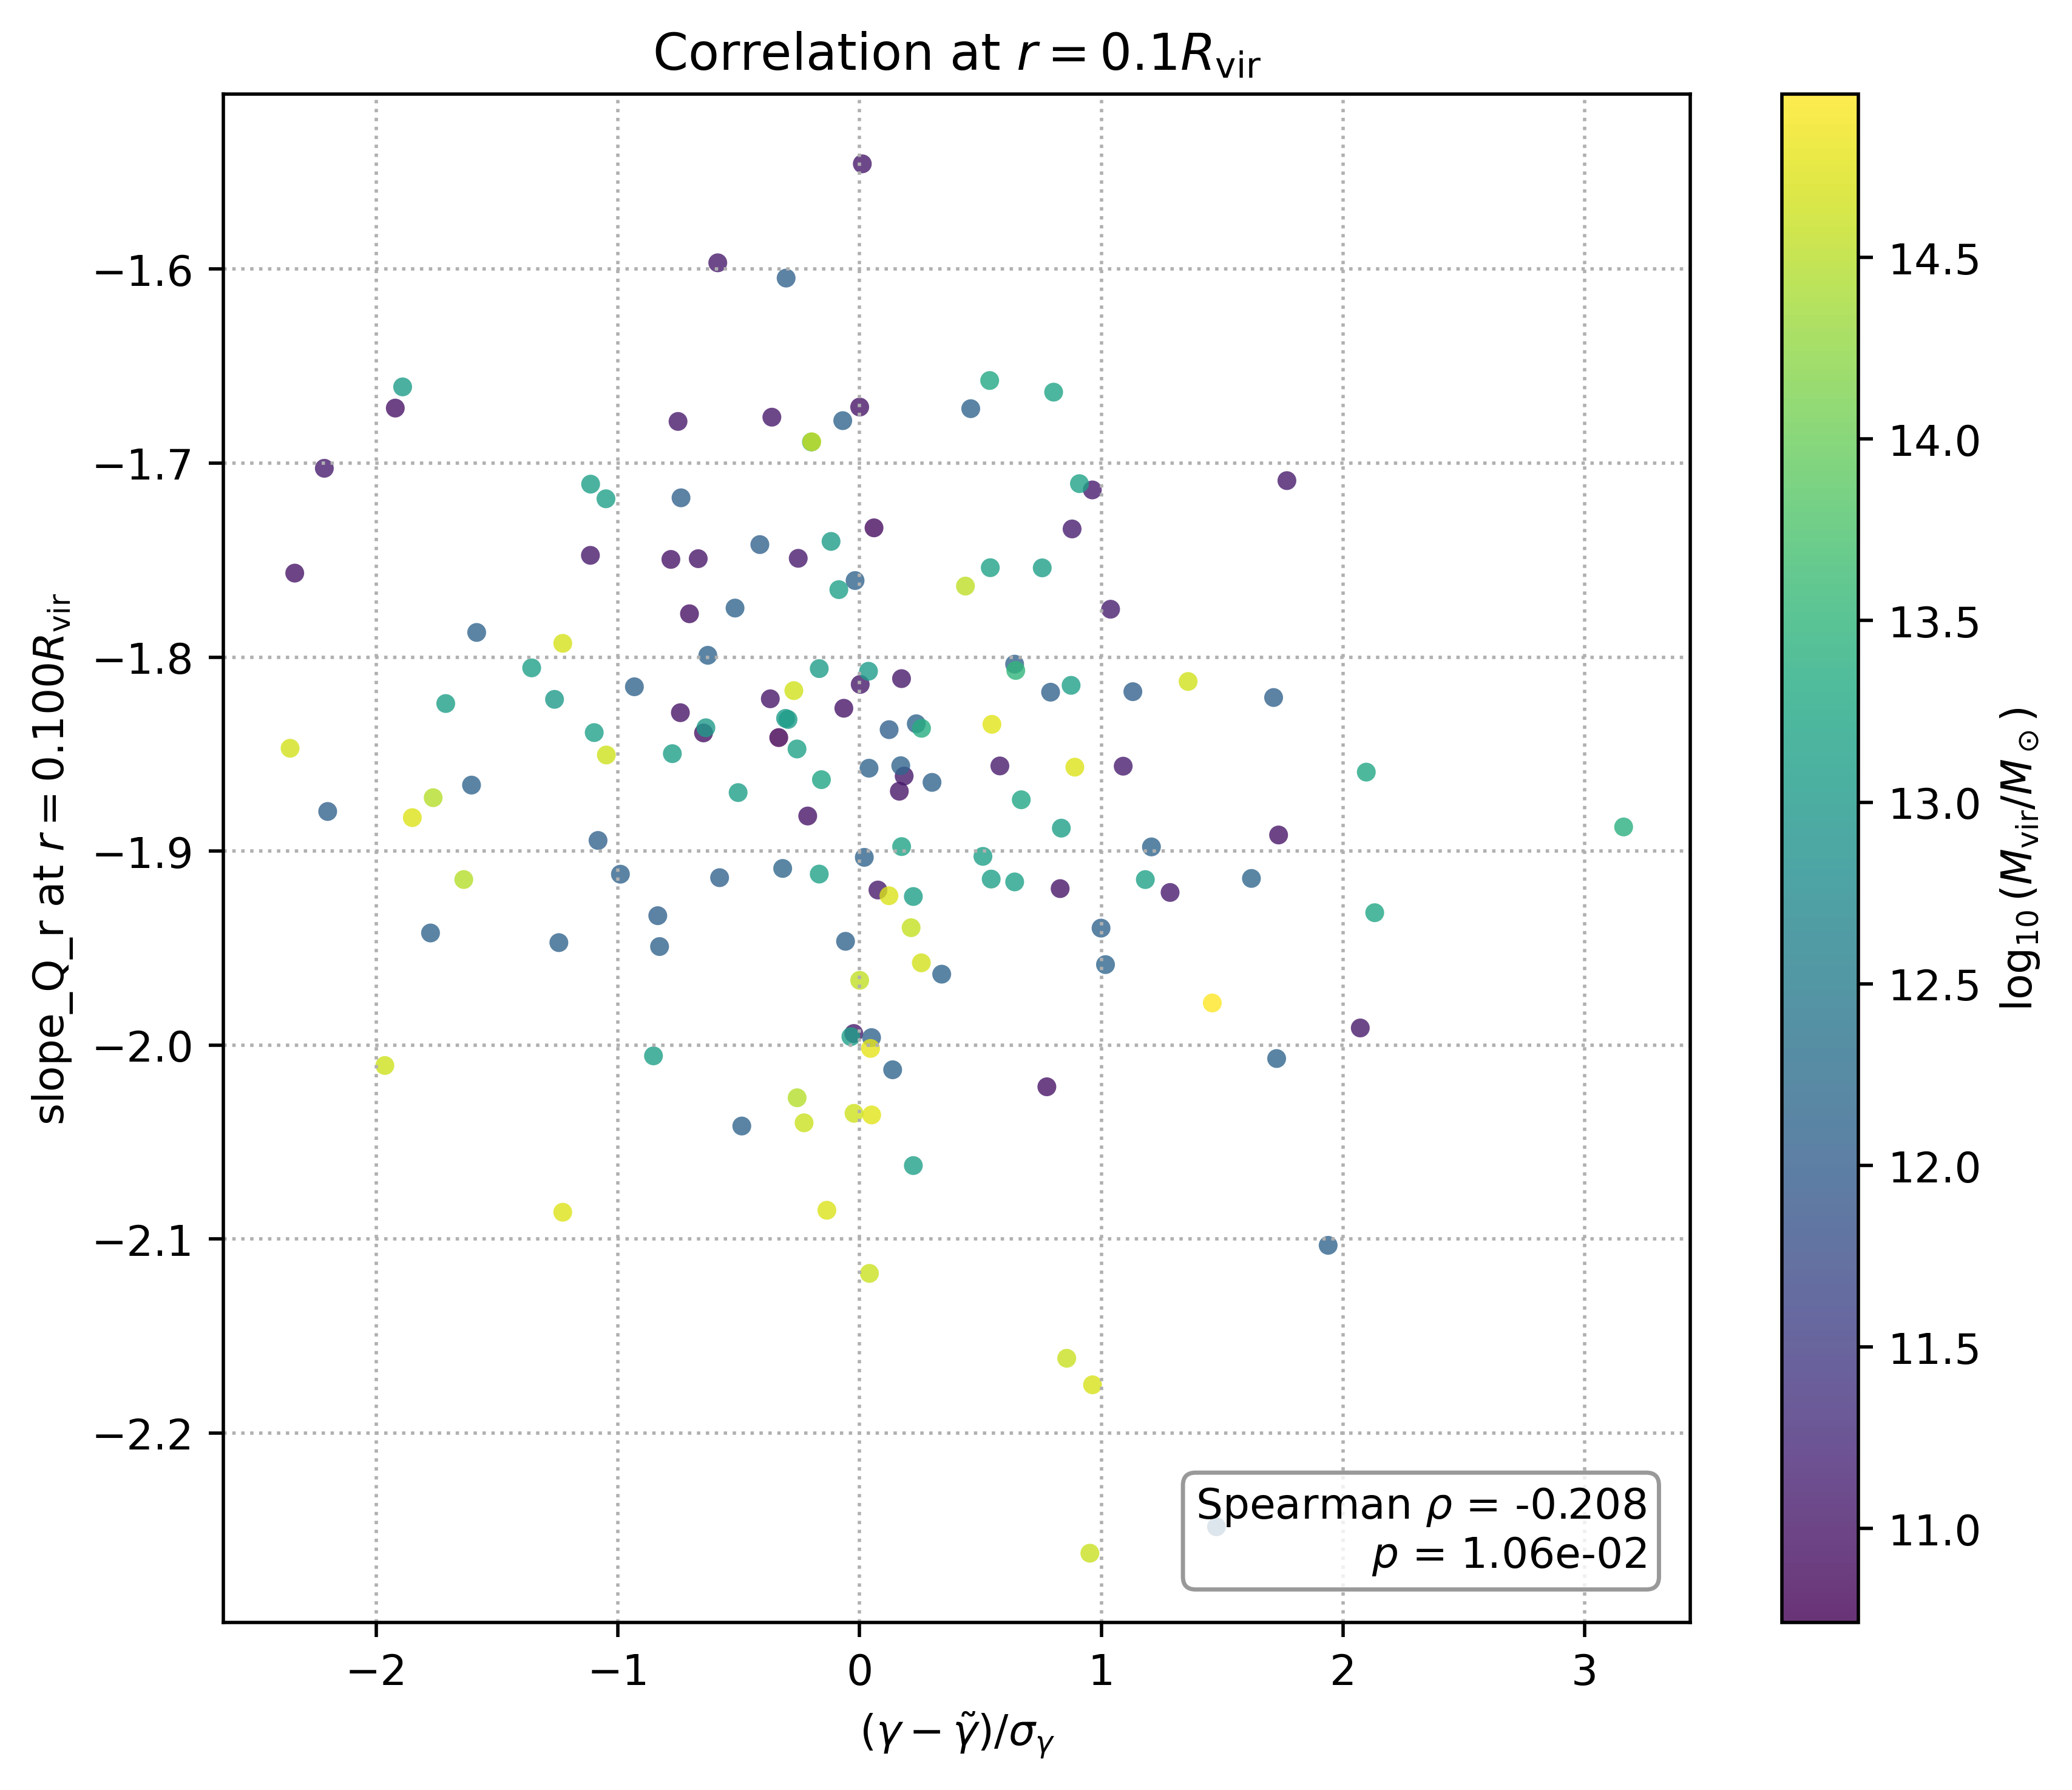

Spearman ρ = -0.344, p = 1.64e-05


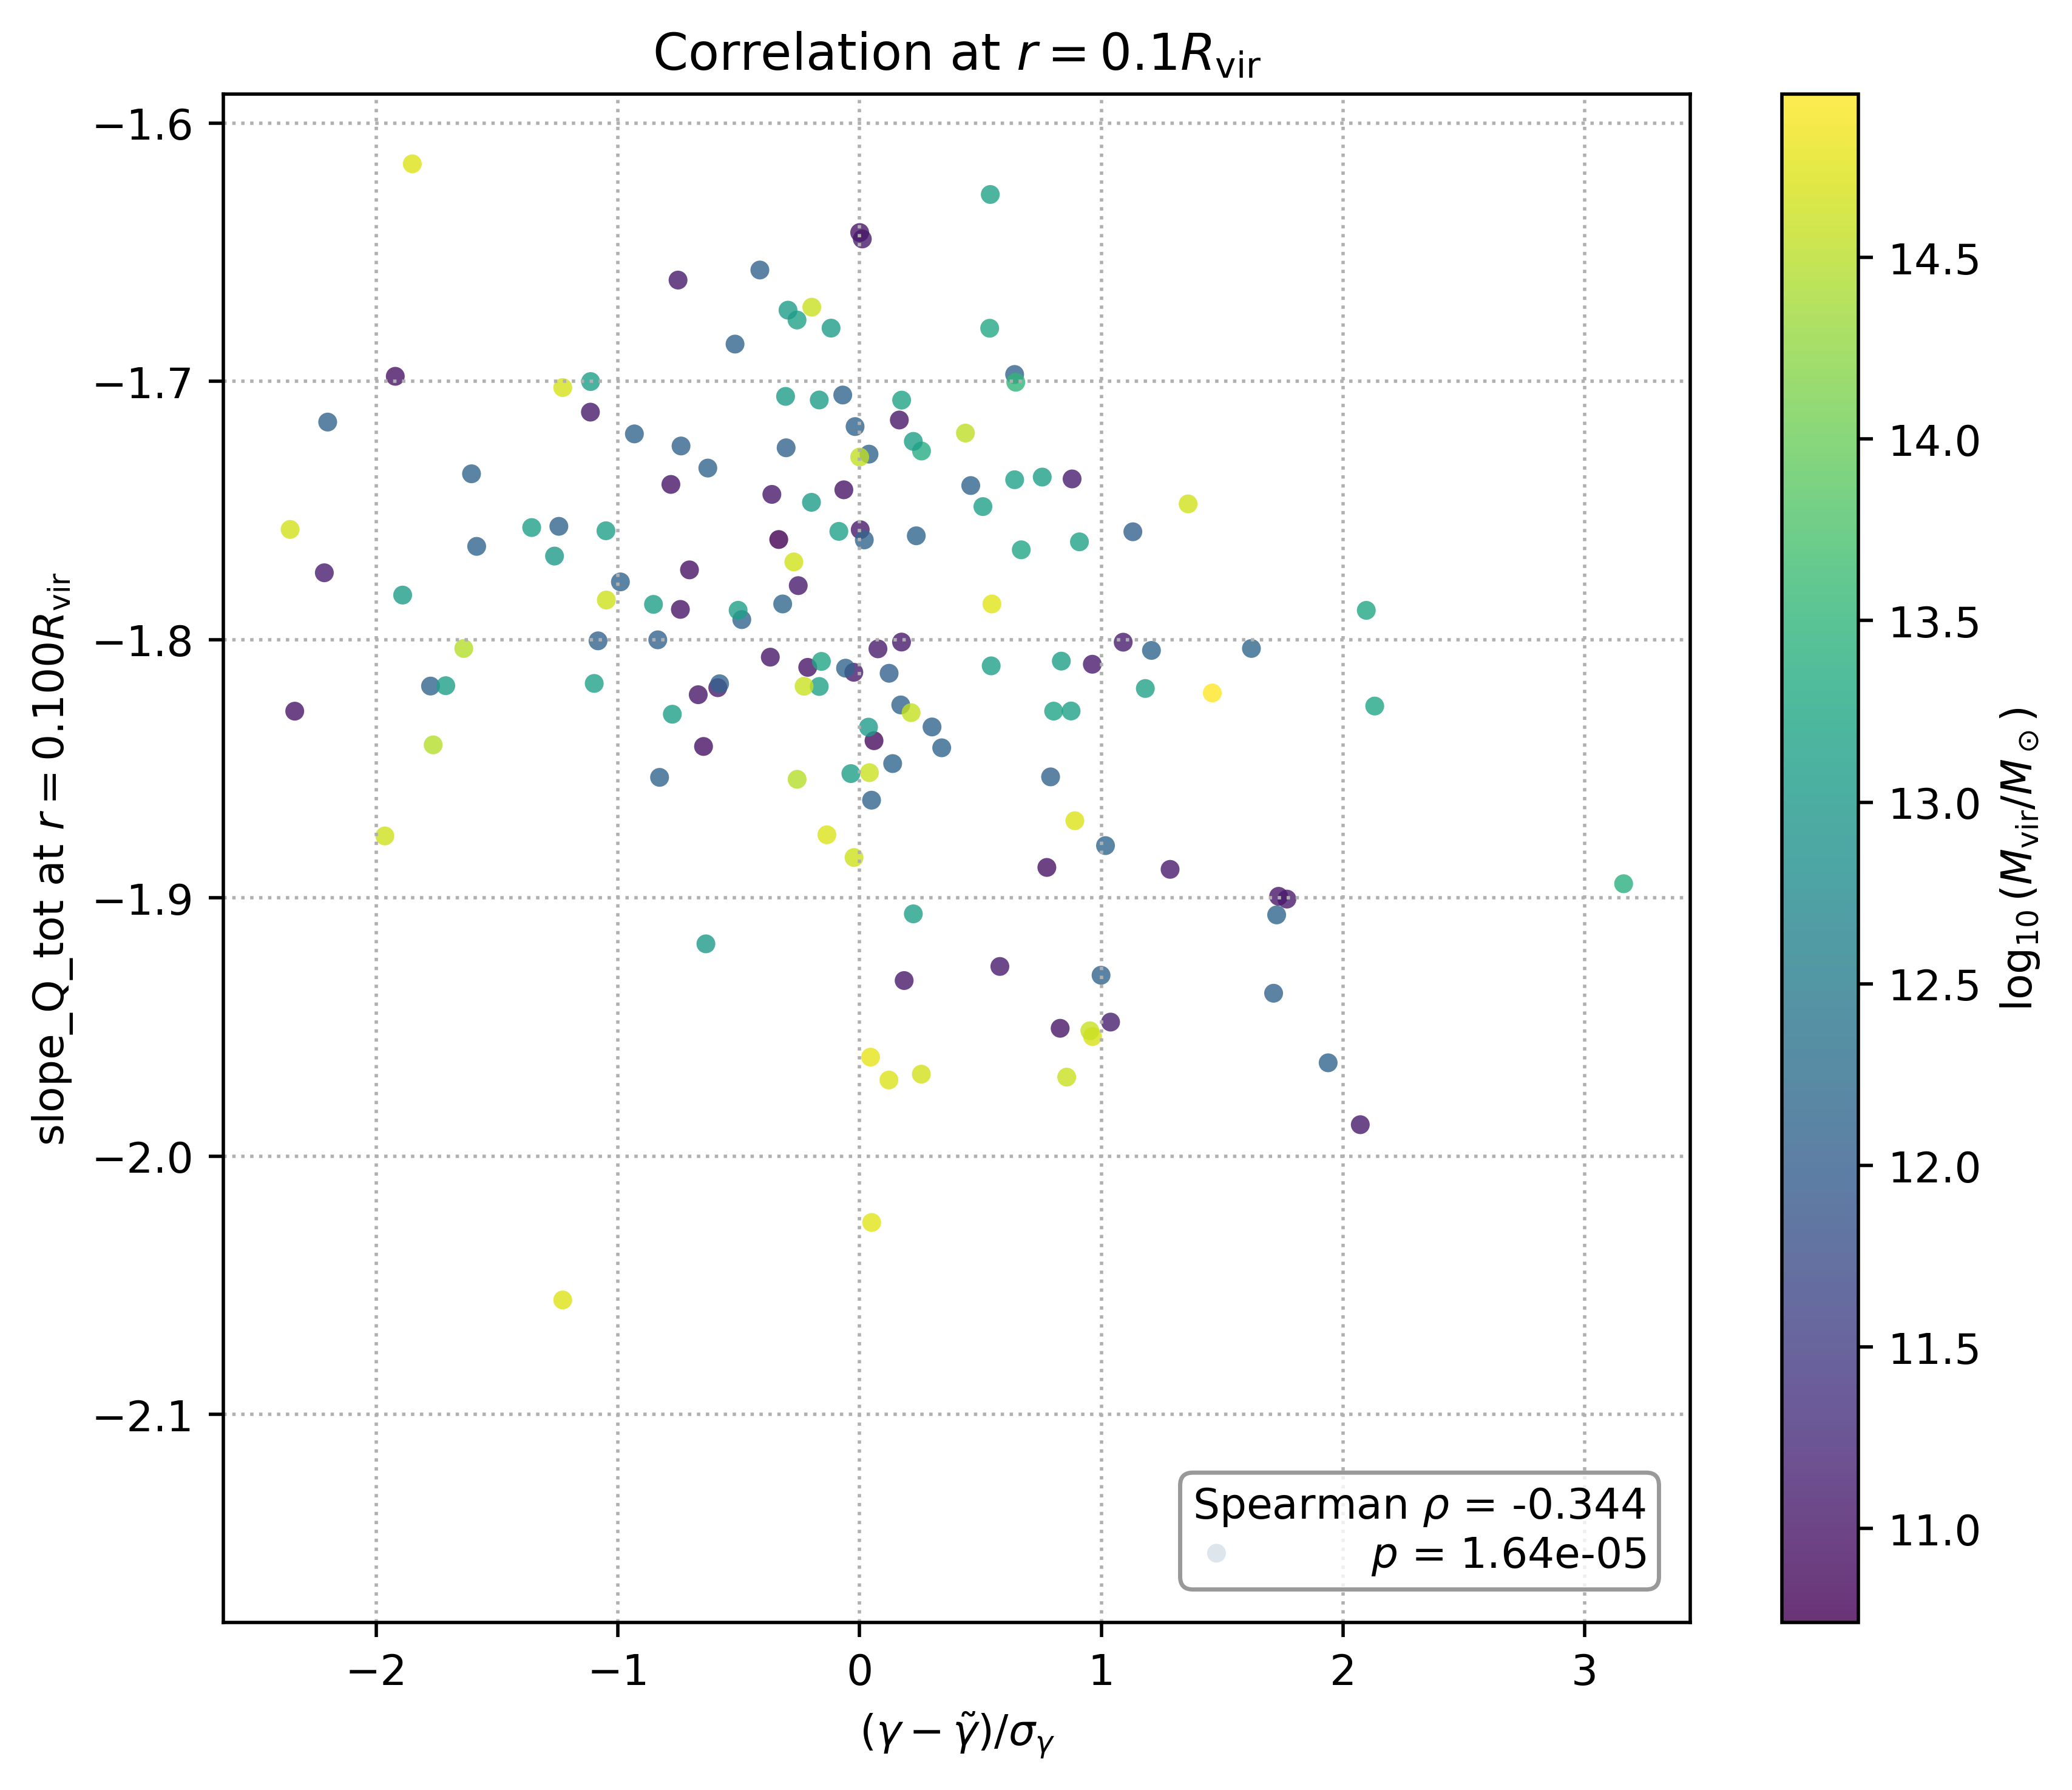

Spearman ρ = -0.070, p = 3.75e-01


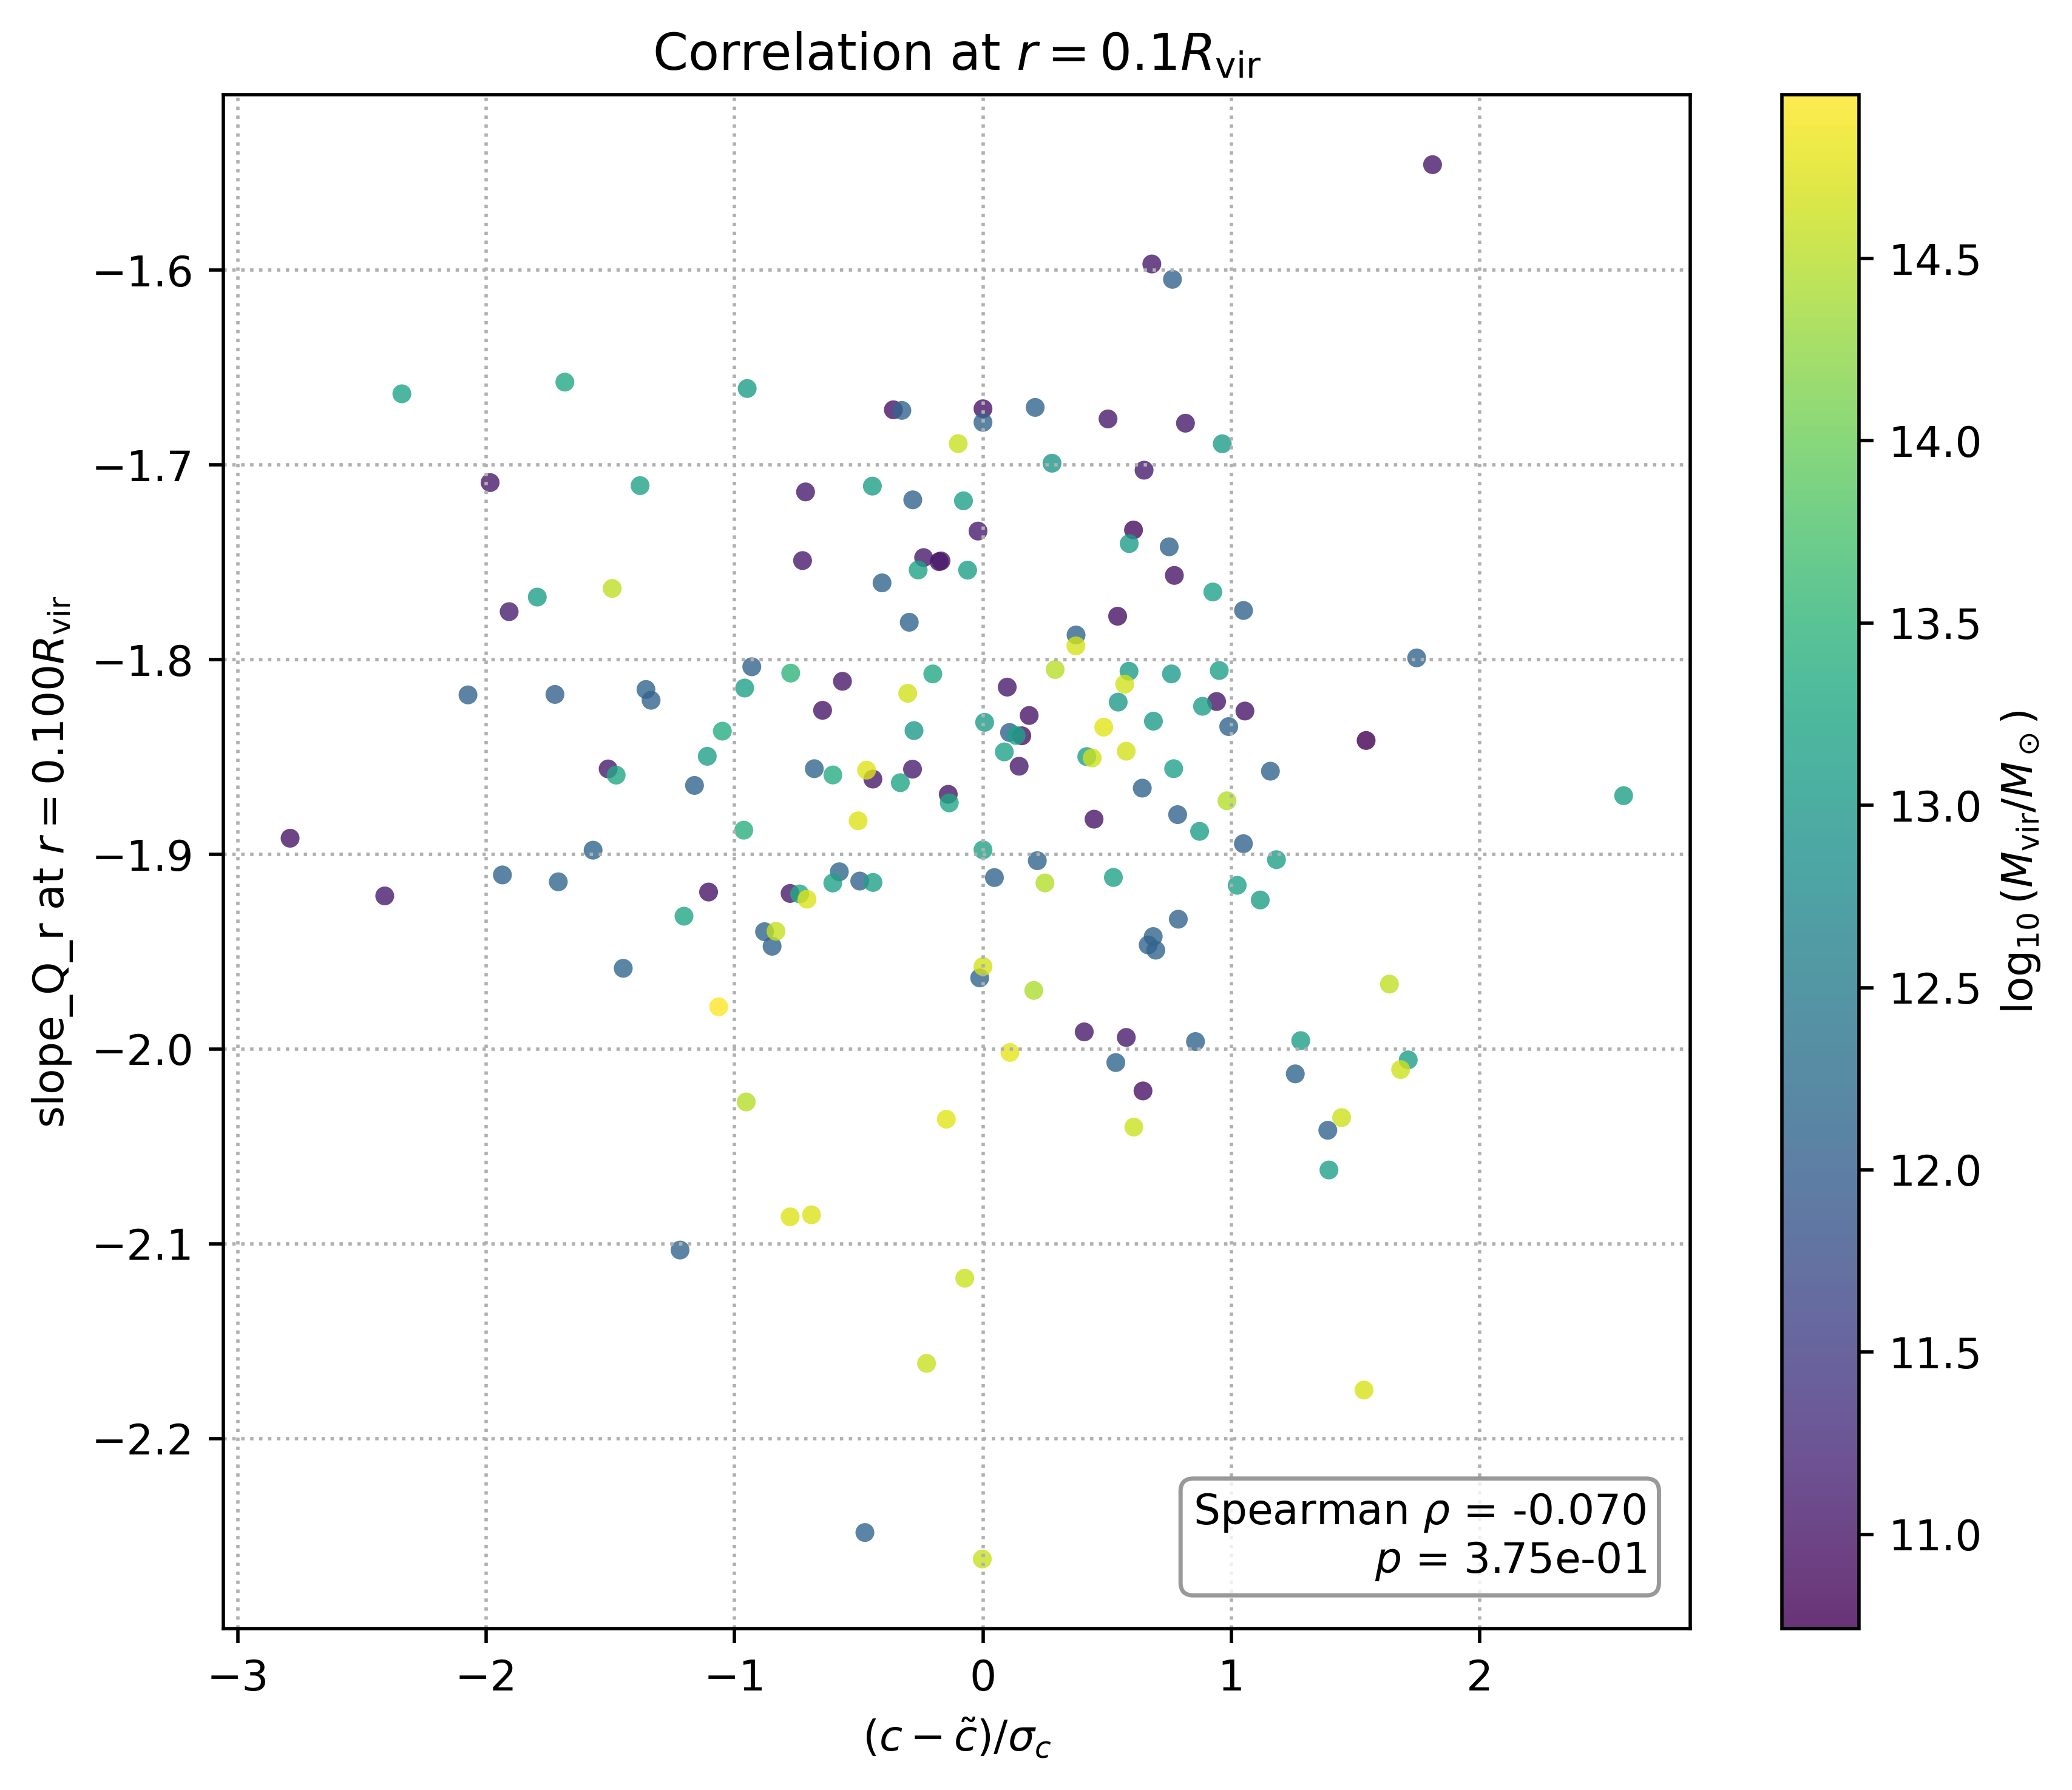

Spearman ρ = 0.194, p = 1.28e-02


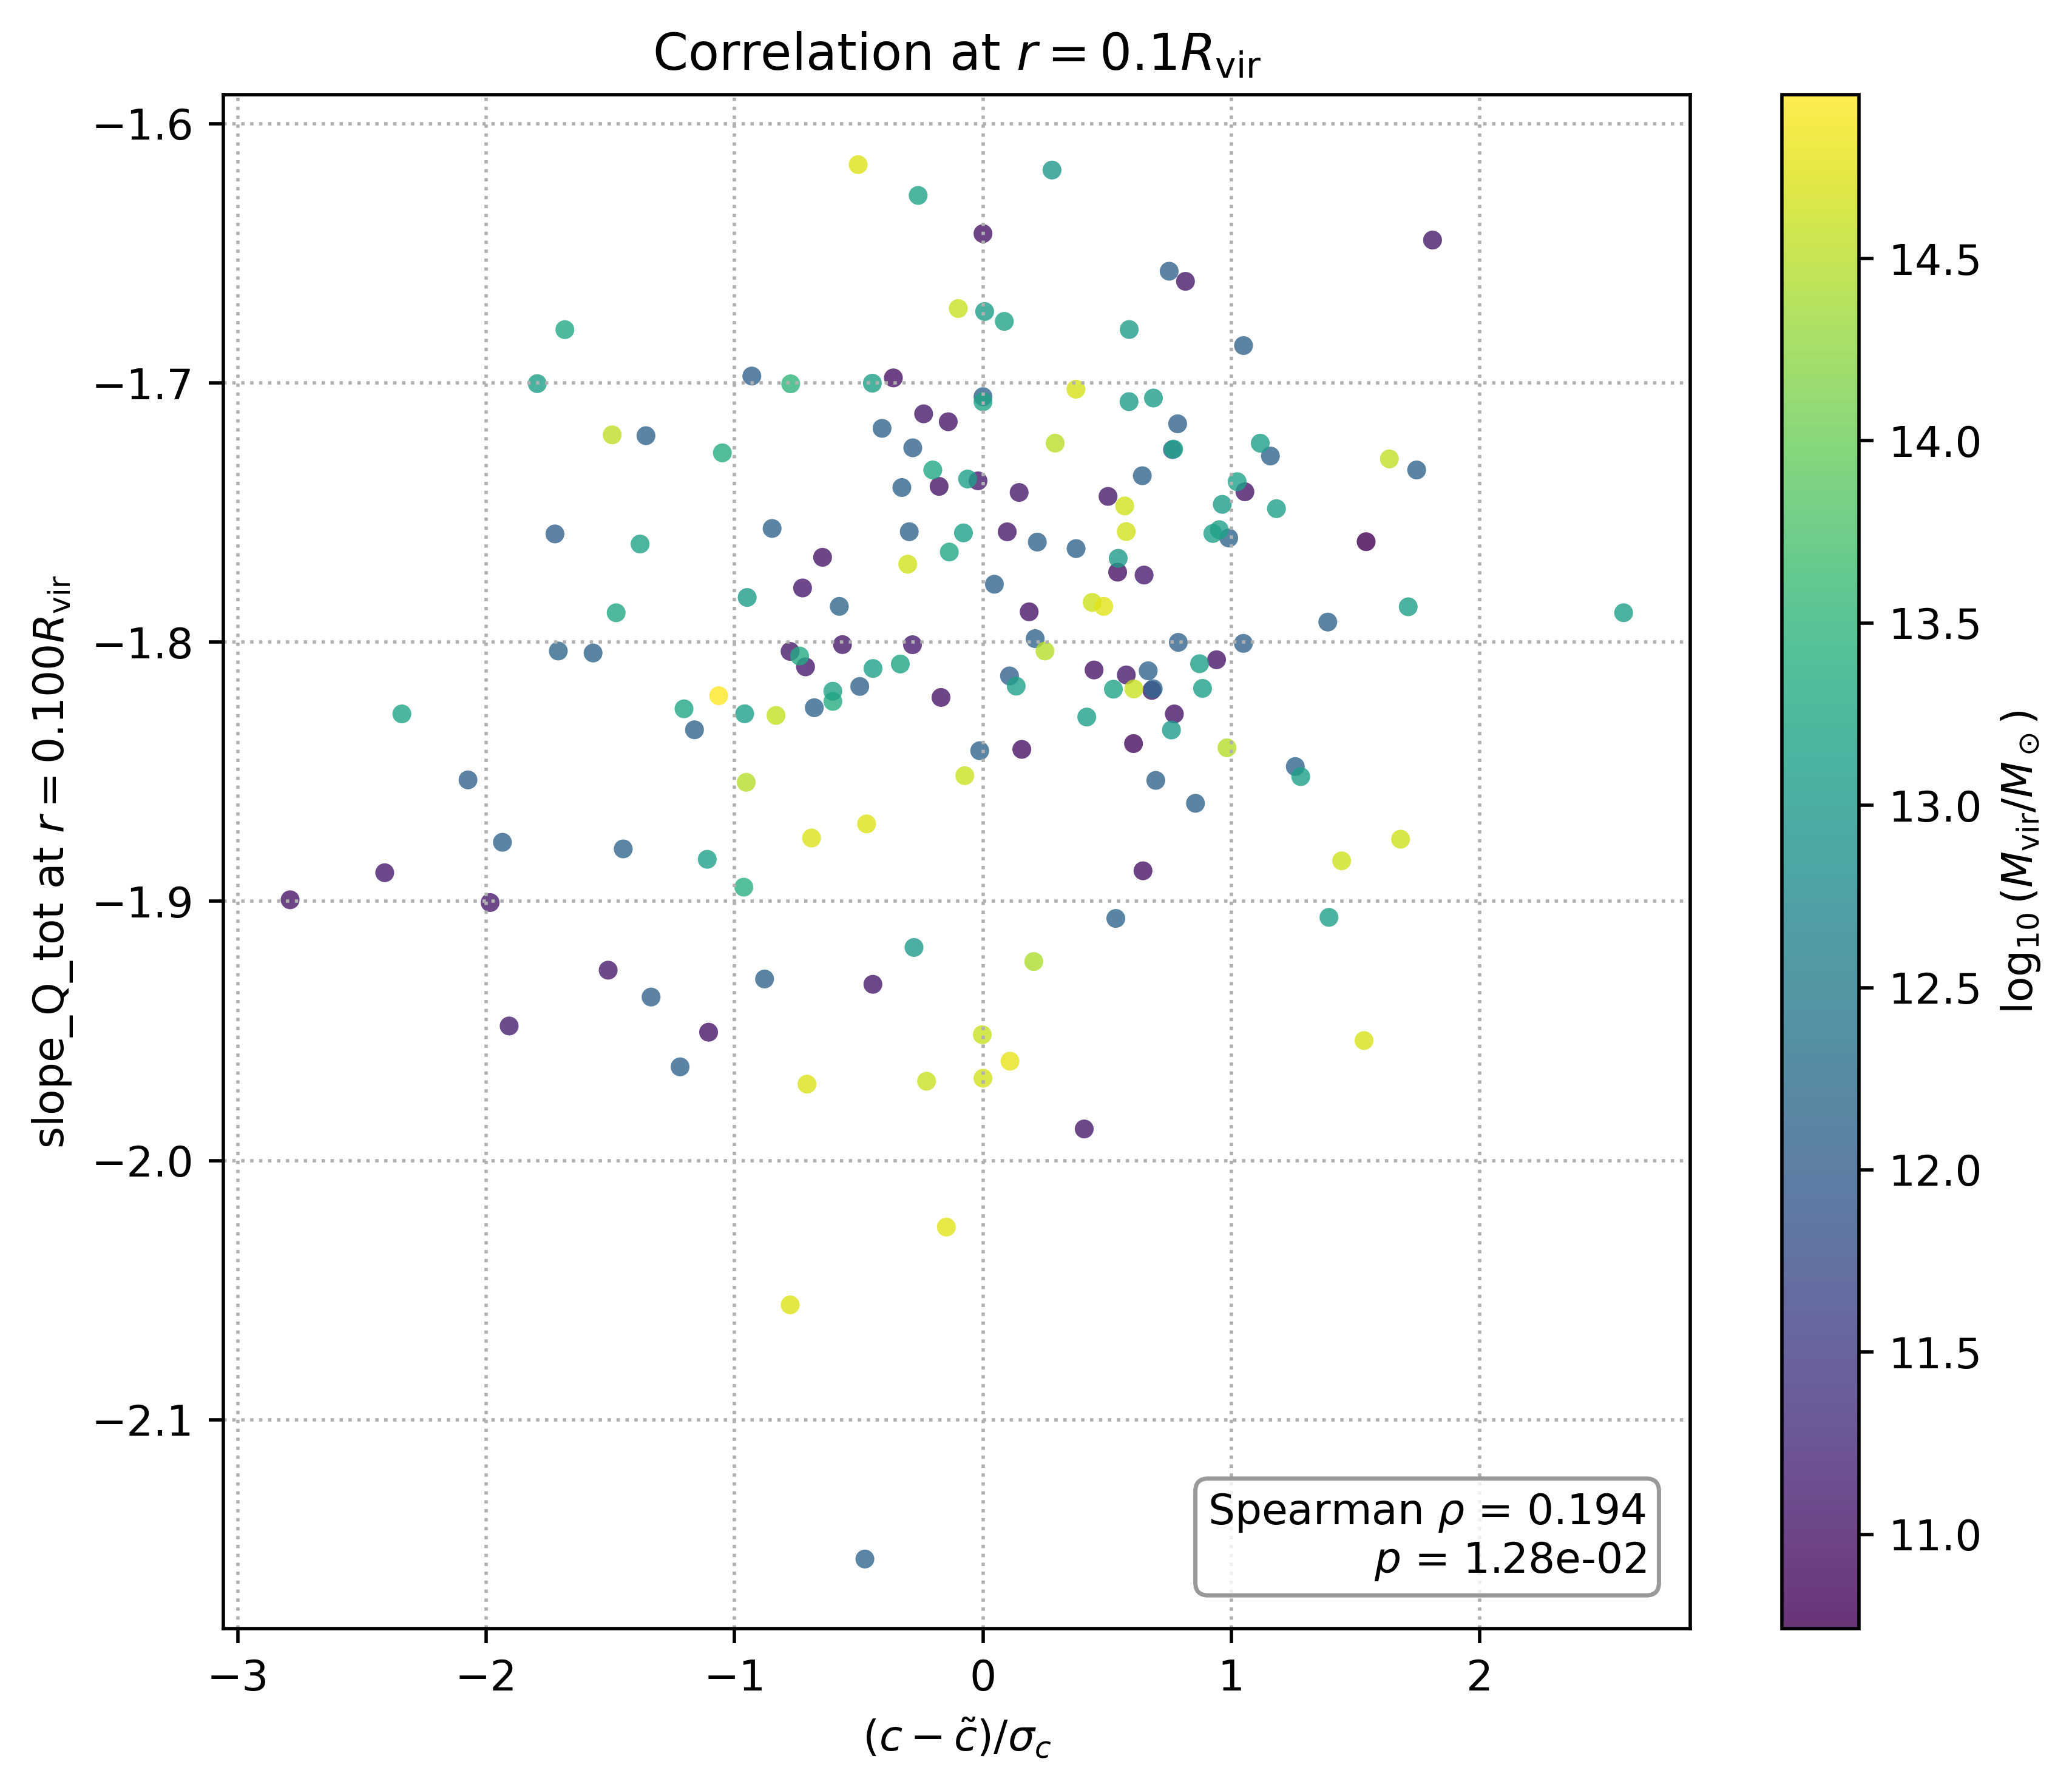

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

def quantify_correlation(base_dir, suite_names, r_target=0.01, x_var="cvir", slope_var="slope_Q_r"):
    slope_vals, x_vals, mass_vals = [], [], []

    for suite in suite_names:
        slope_r_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_cvir = pd.read_csv(cvir_path)
        df_gamma = pd.read_csv(gamma_path)
        cvir_dict = dict(zip(df_cvir["halo_id"], df_cvir["cvir"]))
        gamma_dict = dict(zip(df_gamma["halo_index"], df_gamma["gamma"]))
        mass_dict = dict(zip(pd.read_csv(mass_path)["halo_id"], pd.read_csv(mass_path)["mvir"]))

        if x_var == "delta_c_norm":
            c_vals = df_cvir["cvir"].values
            c_med = np.nanmedian(c_vals)
            c_std = np.nanstd(c_vals)
            delta_c_dict = {row["halo_id"]: (row["cvir"] - c_med) / c_std for _, row in df_cvir.iterrows()}

        elif x_var == "delta_gamma_norm":
            valid_gamma = df_gamma["gamma"].values
            valid_mask = (valid_gamma > 0) & np.isfinite(valid_gamma)
            log_g_vals = np.log10(valid_gamma[valid_mask])

            log_g_med = np.nanmedian(log_g_vals)
            log_g_std = np.nanstd(log_g_vals)

            delta_g_dict = {
                row["halo_index"]: (np.log10(row["gamma"]) - log_g_med) / log_g_std
                for _, row in df_gamma.iterrows()
                if row["gamma"] > 0 and np.isfinite(row["gamma"])
            }

        for f in sorted([f for f in os.listdir(slope_r_dir) if f.endswith(".csv")]):
            try:
                halo_id = int(f.split("_")[1])
                df = pd.read_csv(os.path.join(slope_r_dir, f))
                r = df["r_scaled"].values
                slope = df[slope_var].values
                interp_func = interp1d(r, slope, bounds_error=False, fill_value=np.nan)
                slope_val = float(interp_func(r_target))

                if x_var == "cvir":
                    x = cvir_dict.get(halo_id)
                elif x_var == "gamma":
                    x = gamma_dict.get(halo_id)
                elif x_var == "delta_c_norm":
                    x = delta_c_dict.get(halo_id)
                elif x_var == "delta_gamma_norm":
                    x = delta_g_dict.get(halo_id)
                else:
                    raise ValueError(f"Unsupported x_var: {x_var}")

                mass = mass_dict.get(halo_id, np.nan)
                try:
                    slope_val = float(interp_func(r_target))
                    x = float(x) 
                    mass = float(mass)
                except Exception as e:
                    continue
                if np.isfinite(slope_val) and np.isfinite(x) and (x_var != "gamma" or x > 0):
                    slope_vals.append(slope_val)
                    x_vals.append(x)
                    mass_vals.append(mass)
            except Exception as e:
                print(f"[Warning] Failed to process {f} in {suite}: {e}")
                continue

    slope_vals = np.array(slope_vals)
    x_vals = np.array(x_vals)
    mass_vals = np.array(mass_vals)

    if len(slope_vals) < 2:
        print("[Warning] Not enough valid data to compute correlation.")
        return

    log_mass = np.log10(mass_vals)
    log_x = np.log10(x_vals) if x_var == "gamma" else x_vals

    spearman_r, spearman_p = spearmanr(log_x, slope_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    scatter = plt.scatter(log_x, slope_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8, edgecolors='none')
    cbar = plt.colorbar(scatter, label=r"$\log_{10}(M_{\rm vir} / M_\odot)$")

    xlabel_map = {
        "cvir": r"$c_{\rm vir}$",
        "gamma": r"$\log_{10}(\gamma)$",
        "delta_c_norm": r"$(c - \tilde{c}) / \sigma_c$",
        "delta_gamma_norm": r"$(\gamma - \tilde{\gamma}) / \sigma_\gamma$"
    }
    plt.xlabel(xlabel_map.get(x_var, x_var))
    plt.ylabel(fr"{slope_var} at $r = {r_target:.3f} R_{{\rm vir}}$")
    plt.title(f"Correlation at $r = {r_target} R_{{\\rm vir}}$")
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {spearman_r:.3f}",
        rf"$p$ = {spearman_p:.2e}"
    ))
    plt.text(0.97, 0.03, textstr,
             transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"Spearman ρ = {spearman_r:.3f}, p = {spearman_p:.2e}")
    plt.show()
    
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster"
]
quantify_correlation(
    base_dir, suite_names,
    r_target=0.1,
    x_var="delta_gamma_norm",
    slope_var="slope_Q_r"
)

quantify_correlation(
    base_dir, suite_names,
    r_target=0.1,
    x_var="delta_gamma_norm",
    slope_var="slope_Q_tot"
)

quantify_correlation(
    base_dir, suite_names,
    r_target=0.1,
    x_var="delta_c_norm",
    slope_var="slope_Q_r"
)

quantify_correlation(
    base_dir, suite_names,
    r_target=0.1,
    x_var="delta_c_norm",
    slope_var="slope_Q_tot"
)

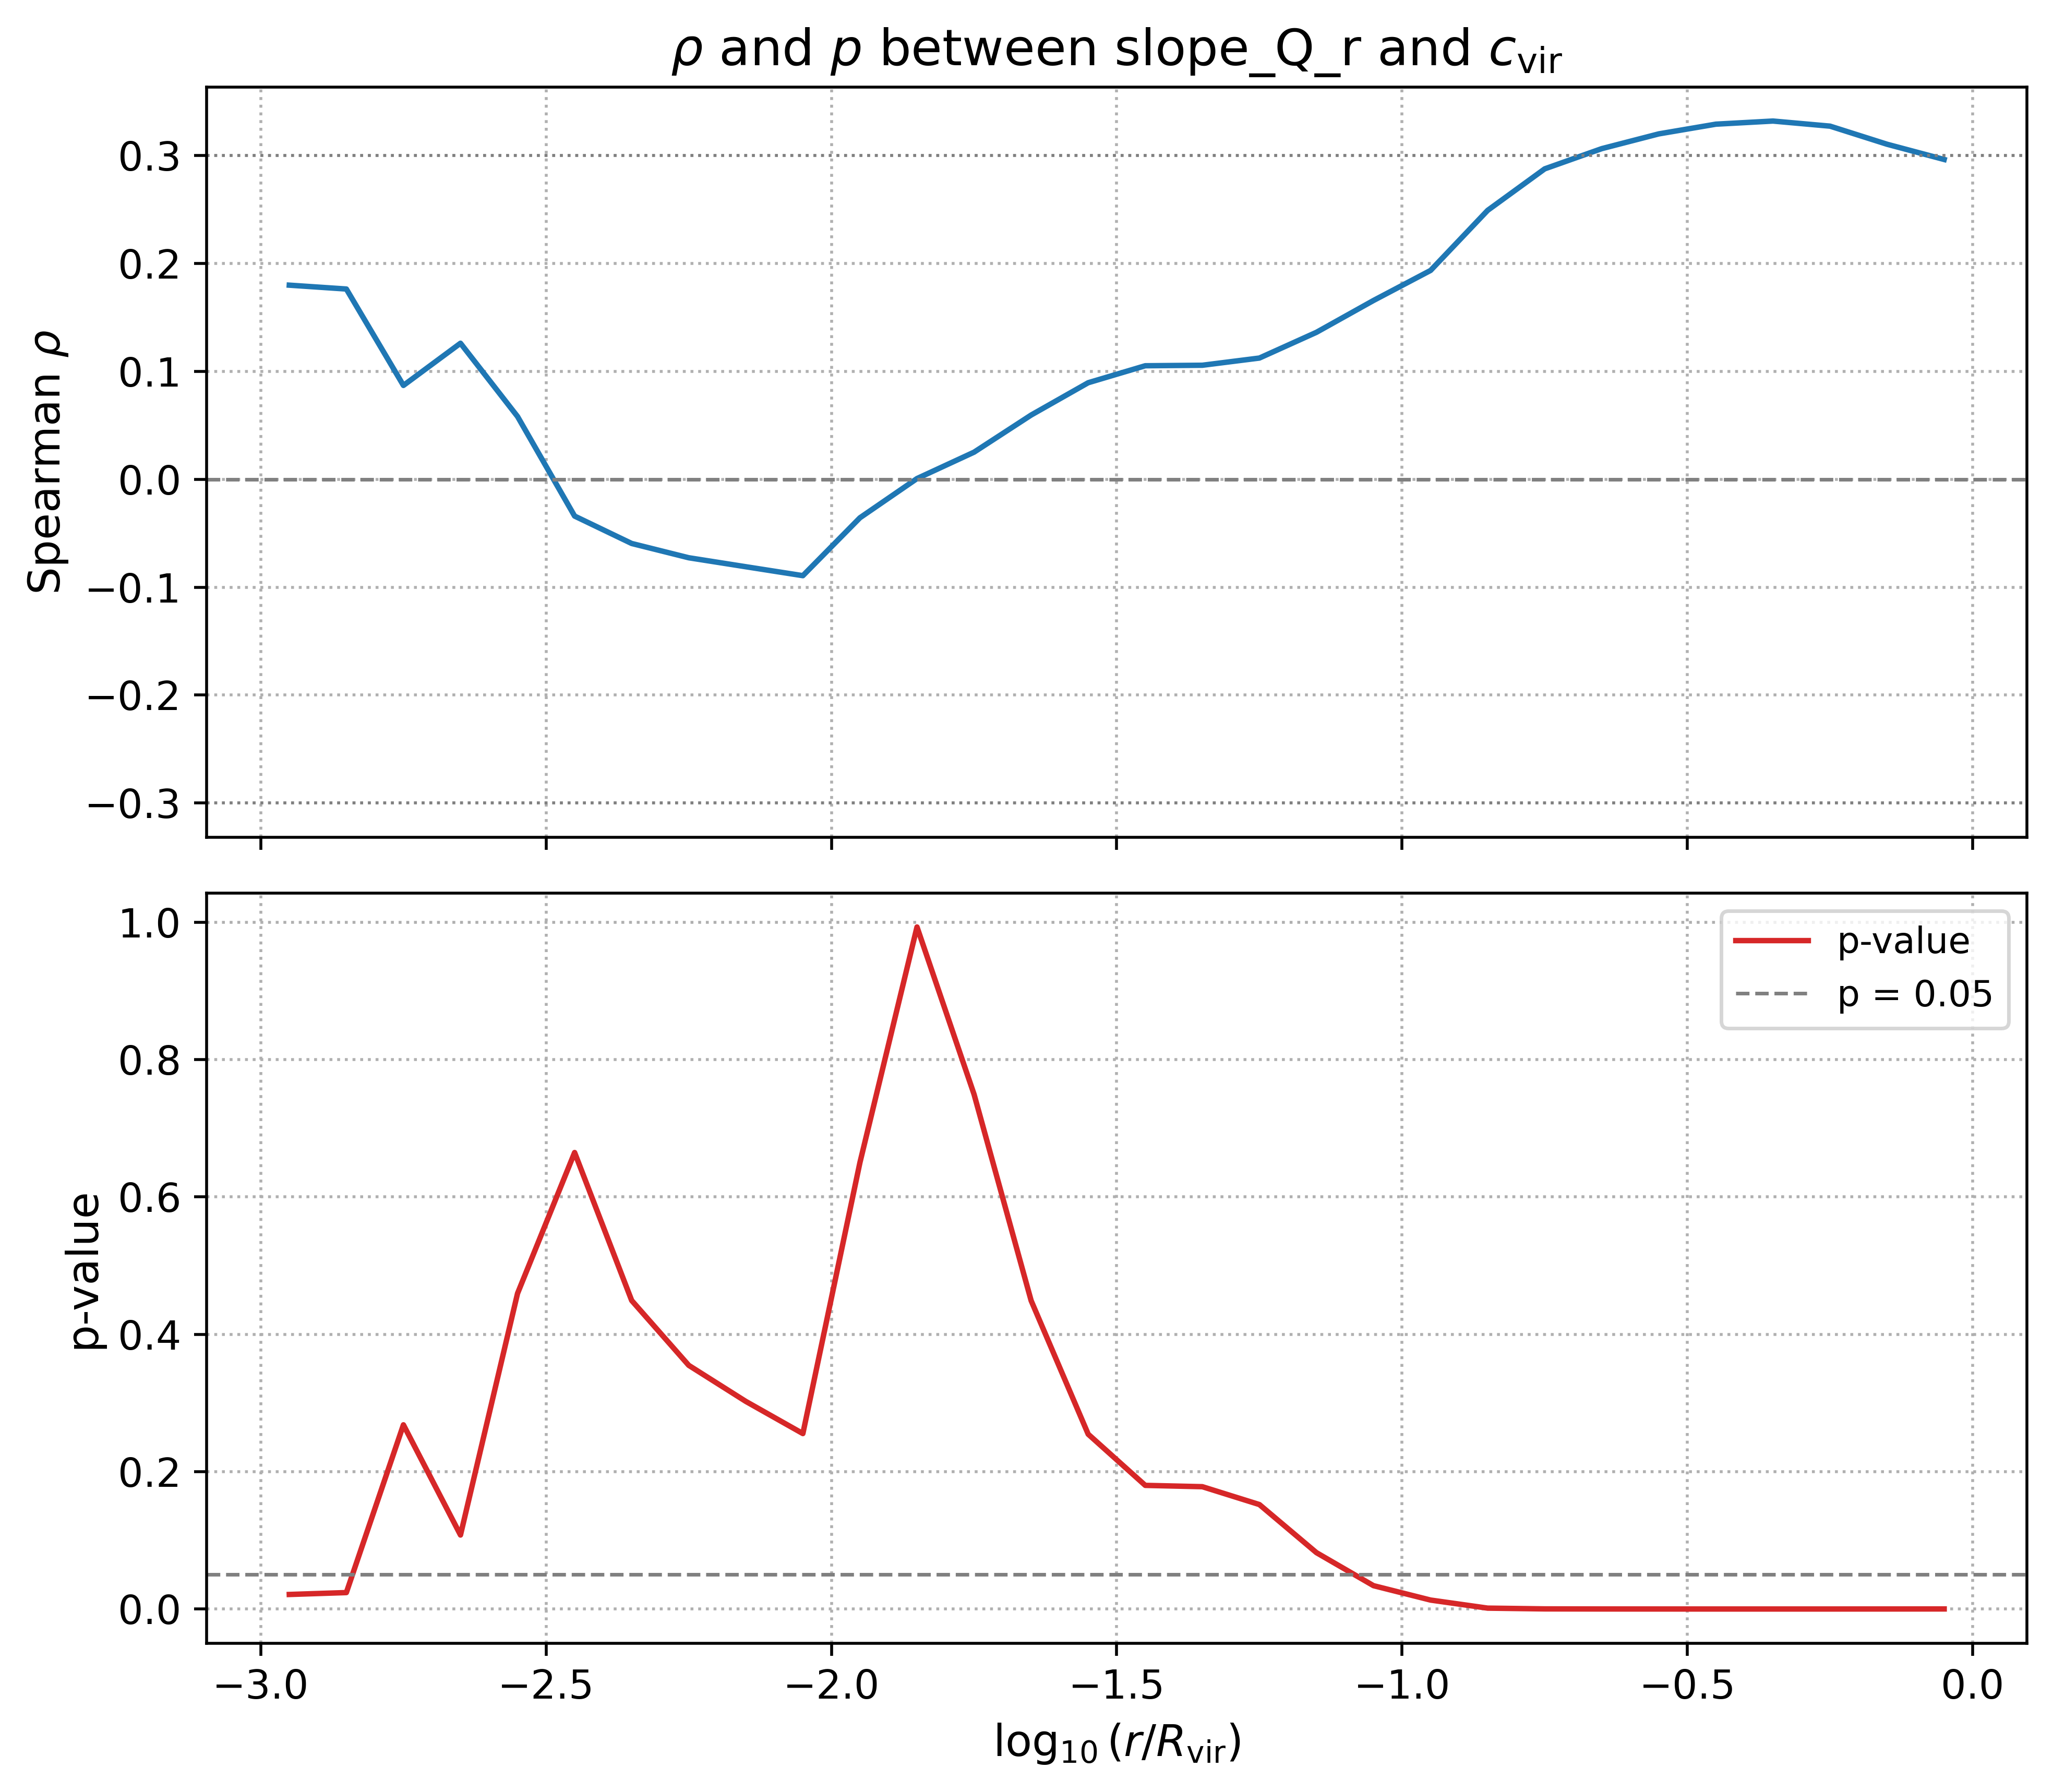

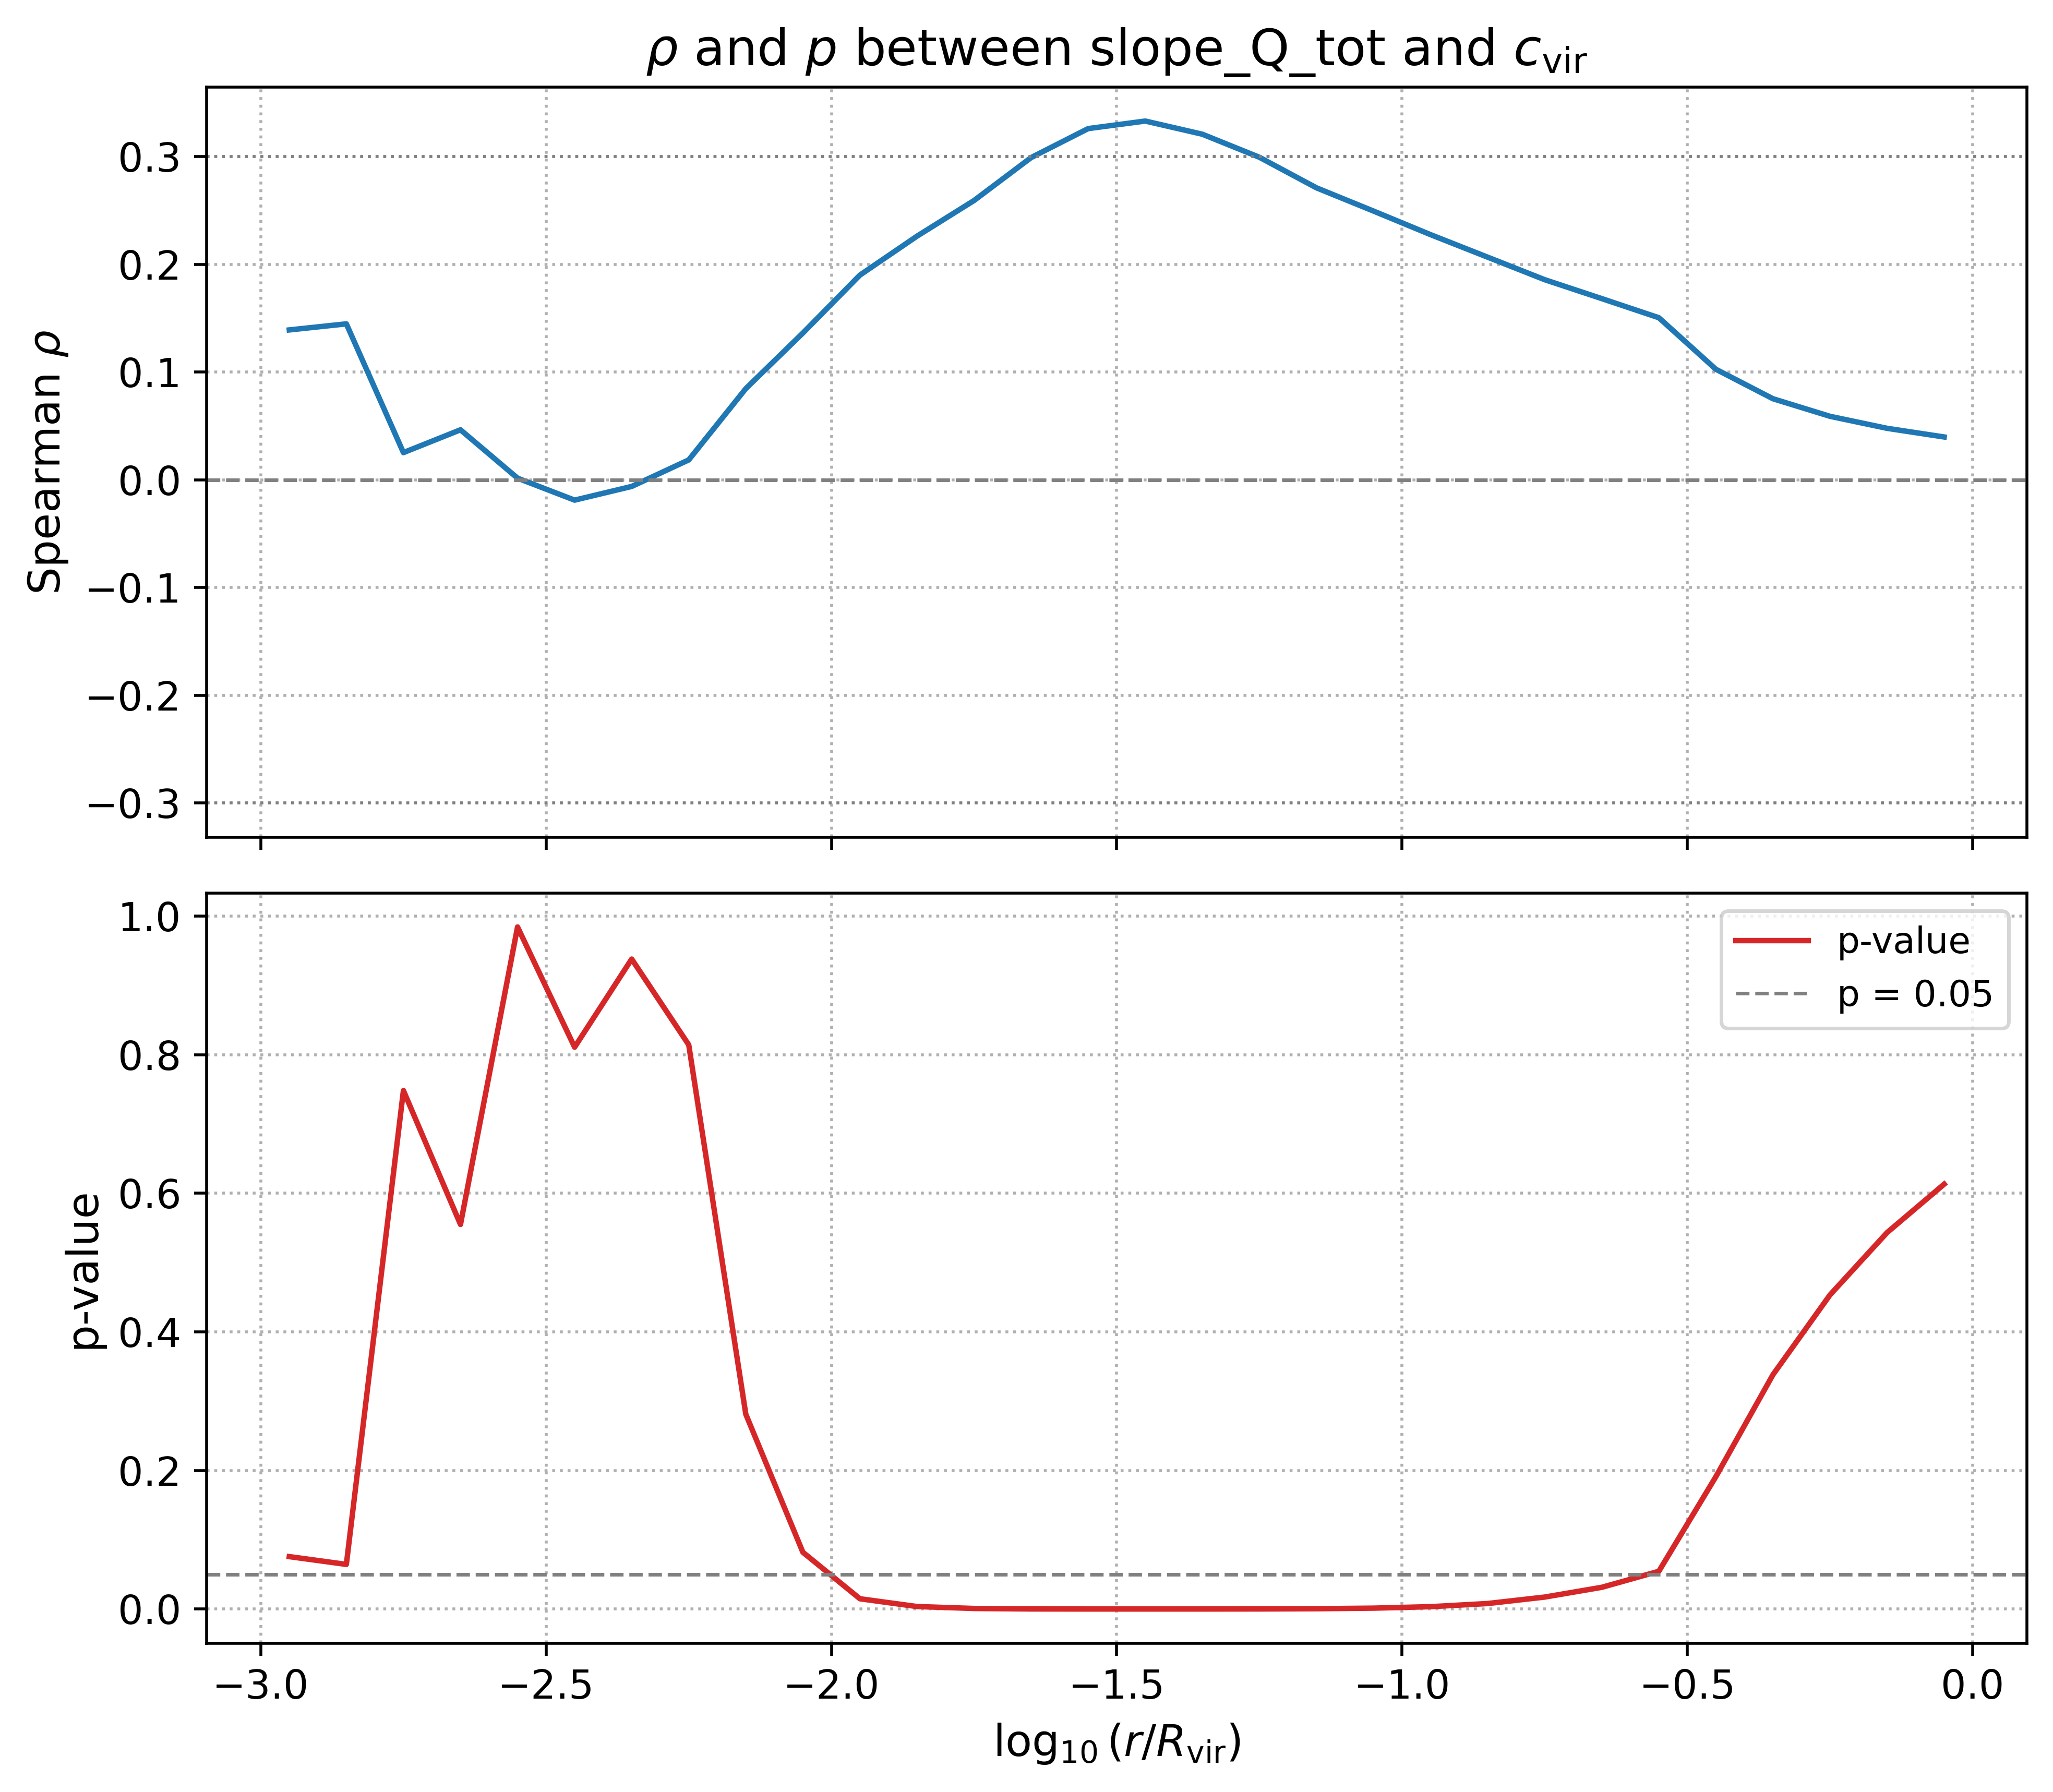

In [163]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

def plot_spearman_r_vs_radius(base_dir, suite_names, x_var="cvir", slope_var="slope_Q_r",
                               log_r_min=-3, log_r_max=0.0, dlogr=0.1):
    """
    Compute and plot Spearman ρ and p as a function of radius between slope and concentration/accretion.
    """
    r_grid = np.logspace(log_r_min, log_r_max, int((log_r_max - log_r_min) / dlogr) + 1)
    r_centers = 10**((np.log10(r_grid[:-1]) + np.log10(r_grid[1:])) / 2)
    rho_vals, p_vals = [], []

    for i in range(len(r_grid) - 1):
        r_lo, r_hi = r_grid[i], r_grid[i+1]
        slopes, xs = [], []

        for suite in suite_names:
            slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
            cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
            gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")

            try:
                cvir_dict = dict(zip(pd.read_csv(cvir_path)["halo_id"], pd.read_csv(cvir_path)["cvir"]))
                gamma_dict = dict(zip(pd.read_csv(gamma_path)["halo_index"], pd.read_csv(gamma_path)["gamma"]))
            except Exception as e:
                print(f"[Warning] Failed to load metadata for {suite}: {e}")
                continue

            for f in sorted([f for f in os.listdir(slope_dir) if f.endswith(".csv")]):
                try:
                    halo_id = int(f.split("_")[1])
                    df = pd.read_csv(os.path.join(slope_dir, f))
                    r = df["r_scaled"].values
                    slope = df[slope_var].values
                    x = cvir_dict.get(halo_id) if x_var == "cvir" else gamma_dict.get(halo_id)

                    if x is None or not np.isfinite(x):
                        continue

                    in_bin = (r >= r_lo) & (r < r_hi)
                    slope_bin = slope[in_bin]
                    if slope_bin.size > 0 and np.any(np.isfinite(slope_bin)):
                        slopes.append(np.nanmean(slope_bin))
                        xs.append(x)
                except Exception as e:
                    print(f"[Warning] Failed to process {f} in {suite}: {e}")
                    continue

        # 计算 Spearman ρ 和 p
        slopes = np.array(slopes)
        xs = np.array(xs)
        valid = np.isfinite(xs) & (xs > 0) & np.isfinite(slopes)
        if np.sum(valid) < 2:
            rho_vals.append(np.nan)
            p_vals.append(np.nan)
            continue

        logx = np.log10(xs[valid]) if x_var == "gamma" else xs[valid]
        slopes = slopes[valid]

        r_val, p_val = spearmanr(logx, slopes)
        rho_vals.append(r_val)
        p_vals.append(p_val)

    # --- 绘图 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True, dpi=500)

    # ρ
    ax1.plot(np.log10(r_centers), rho_vals, label="Spearman ρ", color="tab:blue")
    ax1.axhline(0, ls="--", c="gray", lw=1)
    ax1.axhline(0.3, ls=":", c="gray", lw=0.8)
    ax1.axhline(-0.3, ls=":", c="gray", lw=0.8)
    ax1.set_ylabel(r"Spearman $\rho$")
    ax1.set_title(fr"$\rho$ and $p$ between {slope_var} and " + (r"$\log \gamma$" if x_var == "gamma" else r"$c_{\rm vir}$"))
    ax1.grid(True, linestyle=":")

    # p
    ax2.plot(np.log10(r_centers), p_vals, label="p-value", color="tab:red")
    ax2.axhline(0.05, ls="--", c="gray", lw=1, label="p = 0.05")
    ax2.set_xlabel(r"$\log_{10}(r / R_{\rm vir})$")
    ax2.set_ylabel("p-value")
    ax2.grid(True, linestyle=":")
    ax2.legend()

    plt.tight_layout()
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster"
]

# 浓度与 slope_Q_r 的径向相关性
plot_spearman_r_vs_radius(base_dir, suite_names, x_var="cvir", slope_var="slope_Q_r")

# 吸积率与 slope_Q_tot 的径向相关性
plot_spearman_r_vs_radius(base_dir, suite_names, x_var="cvir", slope_var="slope_Q_tot")